In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import csv
import os
from skimage.metrics import structural_similarity as ssim
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.ndimage.filters import gaussian_filter
import warnings
import gc
warnings.filterwarnings('ignore')


/var/folders/dx/62n3h5k10q5d68qxvqdtsx4h0000gn/T/ipykernel_69578/2902600383.py:10: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [13]:
def extract_key_frames(video_path, save_dir="SavedFrames", csv_dir="CSVFiles", n=1, similarity_threshold=0.95):
    # Open the video file
    video = cv2.VideoCapture(video_path)

    # Initialize frame counter
    count = 0

    # Initialize variable to hold the previous frame
    prev_frame = None

    # Ensure the directories exist
    for directory in [save_dir, csv_dir]:
        if not os.path.exists(directory):
            os.makedirs(directory)

    # Specify the CSV file within the csv_dir
    csv_file = os.path.join(csv_dir, "timestamps.csv")

    # Check if video opened successfully
    if not video.isOpened():
        print("Error opening video file")
        return

    # Open the CSV file in write mode
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        # Write the header to the CSV file
        writer.writerow(["Frame Name", "Timestamp"])

        # Loop until all frames are read
        while video.isOpened():
            # Read a frame
            ret, frame = video.read()

            # Only process every n-th frame
            if ret and count % n == 0:
                # Convert the frame to grayscale
                gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

                # If this isn't the first frame, compare it to the previous one
                if prev_frame is not None:
                    # Compare the current frame with the previous frame
                    similarity, _ = ssim(prev_frame, gray_frame, full=True)

                    # If similarity is below the threshold, save the frame and log the timestamp
                    if similarity < similarity_threshold:
                        # Get the timestamp of the current frame (in milliseconds)
                        timestamp = video.get(cv2.CAP_PROP_POS_MSEC)
                        
                        # Save the frame
                        frame_name = f"frame_{count}.png"
                        full_path = os.path.join(save_dir, frame_name)
                        cv2.imwrite(full_path, frame)

                        # Write the frame name and timestamp to the CSV file
                        writer.writerow([frame_name, timestamp])

                # Update prev_frame
                prev_frame = gray_frame

                count += 1

            elif not ret:
                
                break

    # Release the video file
    video.release()

# Call the function
video_path = "/Users/mohammedelsayed/Desktop/dessertaion files /clustring/video.mp4"
extract_key_frames(video_path)


In [4]:
def extract_features(image_path):
    image = cv2.imread(image_path)
    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Compute a 3D histogram in the HSV color space
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8], [0, 180, 0, 256, 0, 256])
    # Normalize and flatten the histogram
    return cv2.normalize(hist, hist).flatten()

frame_dir = "/Users/mohammedelsayed/Desktop/dessertaion files /clustring/SavedFrames"
frame_files = [os.path.join(frame_dir, f) for f in os.listdir(frame_dir) if f.endswith('.png')]
features = [extract_features(f) for f in frame_files]

In [5]:
pca = PCA(n_components=50)  # You can adjust the number of components
reduced_features = pca.fit_transform(features)

In [6]:
kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(reduced_features)

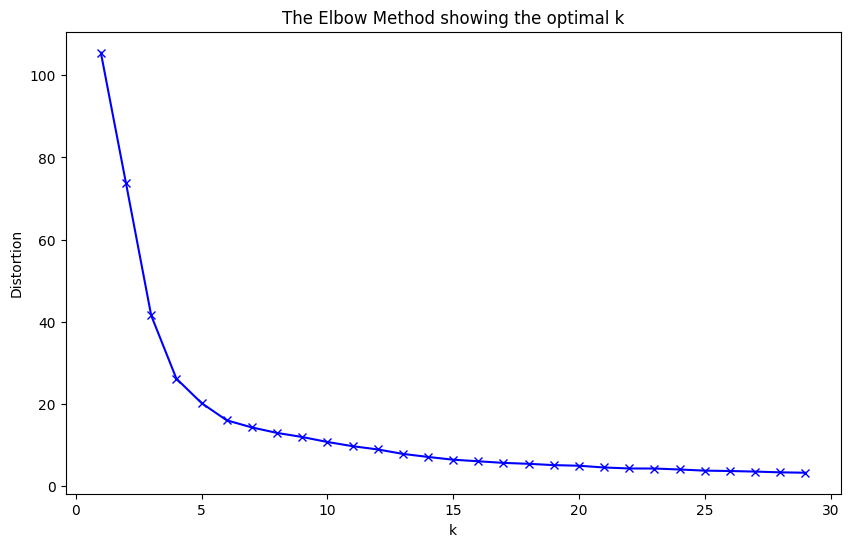

In [7]:
distortions = []
K = range(1, 30)  
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(reduced_features)
    distortions.append(kmeanModel.inertia_)

# Plotting the distortions to visualize the "elbow"
plt.figure(figsize=(10,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [8]:
def closest_frame_to_centroid(cluster_center, features):
    """Return the index of the frame closest to the cluster centroid."""
    distances = np.linalg.norm(features - cluster_center, axis=1)
    return np.argmin(distances)

# After clustering
optimal_clusters = KMeans(n_clusters=10)  
optimal_clusters.fit(reduced_features)

key_frame_indices = [closest_frame_to_centroid(center, reduced_features) for center in optimal_clusters.cluster_centers_]

# Saving the key frames
key_frame_dir = "KEY_FRAMES"  
if not os.path.exists(key_frame_dir):
    os.makedirs(key_frame_dir)

for index in key_frame_indices:
    key_frame_path = frame_files[index]
    destination_path = os.path.join(key_frame_dir, os.path.basename(key_frame_path))
    cv2.imwrite(destination_path, cv2.imread(key_frame_path))


In [9]:
# Load the gaze data and timestamps
gaze_data_path = "/Users/mohammedelsayed/Desktop/dessertaion files /clustring/001_Wu,yu Hsuan.csv"  
df_gaze = pd.read_csv(gaze_data_path)
df_timestamps = pd.read_csv("/Users/mohammedelsayed/Desktop/dessertaion files /clustring/CSVFiles/timestamps.csv")  

# 1. Extract the list of key frames from the directory
key_frame_dir = "/Users/mohammedelsayed/Desktop/dessertaion files /clustring/KEY_FRAMES"
key_frame_files = [f for f in os.listdir(key_frame_dir) if f.endswith('.png')]

# 2. Match these key frames with their timestamps
key_frame_timestamps = df_timestamps[df_timestamps['Frame Name'].isin(key_frame_files)]

# 3. Filter the gaze data for each key frame's timestamp and save them
save_dir = "data_for_key_frames"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for i, row in key_frame_timestamps.iterrows():
    start_time = row['Timestamp']
    end_time = key_frame_timestamps.iloc[i + 1]['Timestamp'] if i < len(key_frame_timestamps) - 1 else float('inf')
    
    # Filter the gaze data for this time interval
    filtered_gaze = df_gaze[(df_gaze['Timestamp'] >= start_time) & (df_gaze['Timestamp'] < end_time)]
    
    # Save the filtered gaze data
    filtered_gaze.to_csv(os.path.join(save_dir, f"gaze_data_for_{row['Frame Name'].replace('.png', '.csv')}"), index=False)


In [10]:

key_frame_dir = "/Users/mohammedelsayed/Desktop/dessertaion files /clustring/KEY_FRAMES"
gaze_data_dir = "/Users/mohammedelsayed/Desktop/dessertaion files /clustring/data_for_key_frames"
output_dir = "heatmaps"

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Iterate over each key frame
for frame_name in os.listdir(key_frame_dir):
    if frame_name.endswith('.png'):
        
        # Load the key frame
        frame_path = os.path.join(key_frame_dir, frame_name)
        frame_img = cv2.cvtColor(cv2.imread(frame_path), cv2.COLOR_BGR2RGB)
        
        # Load the corresponding gaze data
        gaze_data_name = f"gaze_data_for_{frame_name.replace('.png', '.csv')}"
        gaze_data_path = os.path.join(gaze_data_dir, gaze_data_name)
        gaze_data = pd.read_csv(gaze_data_path)
        
        # Compute the mean X and Y gaze coordinates
        gaze_data['Mean_X'] = (gaze_data['ET_GazeRightx'] + gaze_data['ET_GazeLeftx']) / 2
        gaze_data['Mean_Y'] = (gaze_data['ET_GazeLefty'] + gaze_data['ET_GazeRighty']) / 2
        
        # Filter out NaN values
        gaze_data = gaze_data.dropna(subset=['Mean_X', 'Mean_Y'])
        
        # Generate a density heatmap
        heatmap_density = np.zeros_like(frame_img[:, :, 0], dtype=np.float32)
        for x, y in zip(gaze_data['Mean_X'], gaze_data['Mean_Y']):
            if 0 <= int(y) < heatmap_density.shape[0] and 0 <= int(x) < heatmap_density.shape[1]:
                heatmap_density[int(y), int(x)] += 1
        heatmap_density = gaussian_filter(heatmap_density, sigma=(30, 30))
        
        # Combine the frame and heatmap
        plt.figure(figsize=(10, 10))
        plt.imshow(frame_img)
        plt.imshow(heatmap_density, alpha=0.6, cmap='hot')
        plt.axis('off')
        
        # Save the heatmap
        output_path = os.path.join(output_dir, f"heatmap_for_{frame_name}")
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
        plt.close()

print("Heatmaps generated and saved!")


Heatmaps generated and saved!
